In [42]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
color_image, depth_image, mask_image = cv2.imread('assets/color_image.png'), cv2.imread('assets/depth_image.png', cv2.IMREAD_UNCHANGED), cv2.imread('assets/mask_image.png', cv2.IMREAD_UNCHANGED)

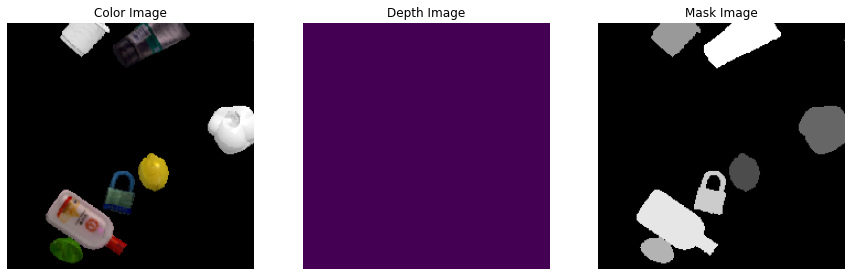

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(color_image)
plt.title('Color Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(depth_image, cmap='gray')
plt.title('Depth Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(mask_image, cmap='gray')
plt.title('Mask Image')
plt.axis('off')
plt.show()

In [12]:
np.where(depth_image != 0)

(array([], dtype=int64), array([], dtype=int64))

In [9]:
import cv2
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from sam_hq.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "assets/sam_hq_vit_b.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

<All keys matched successfully>


torch.Size([16, 1, 224, 224])


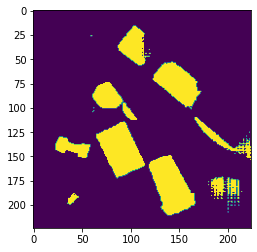

In [17]:
image = cv2.imread('assets/heightmap.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)


num_grids = 4
grid_size = 224 // num_grids
boxes = np.zeros((num_grids * num_grids, 4), dtype=int)
index = 0
for i in range(num_grids):
    for j in range(num_grids):
        top_left_x = i * grid_size
        top_left_y = j * grid_size
        bottom_right_x = (i + 1) * grid_size - 1
        bottom_right_y = (j + 1) * grid_size - 1
        boxes[index] = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
        index += 1

input_boxes = th.tensor(boxes, device=device)  
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])  
masks, iou_predictions, low_res_masks = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=True
)
print(masks.shape)
# merge the masks
# merged_masks = masks.sum(dim=0)
merged_masks = th.zeros_like(masks[0])
for mask in masks:
    merged_masks += mask
plt.imshow(merged_masks.cpu().numpy()[0])

In [6]:
embed = predictor.get_image_embedding()
print(embed.shape)

torch.Size([1, 256, 64, 64])


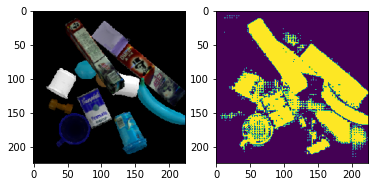

In [25]:
plt.subplot(1, 2, 1)
plt.imshow(image)
masks, scores, logits = predictor.predict(
            box=np.array([0, 0, 223, 223]),
            multimask_output=False,
        )

plt.subplot(1, 2, 2)
plt.imshow(masks[0])

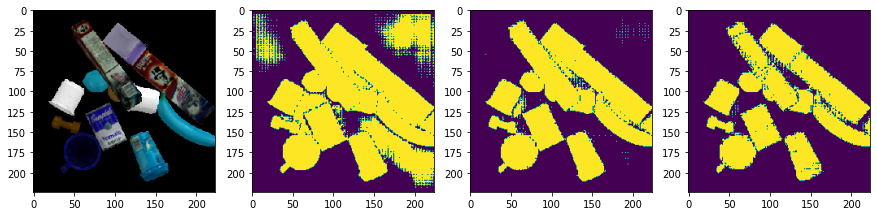

In [23]:
image = cv2.imread('assets/heightmap.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)


# draw center points
# for point in center_points:
#     cv2.circle(image, (point[0], point[1]), 2, (255, 0, 0), -1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(image)

for idx, num_grids in enumerate([16, 32, 64]):
    center_points = []

    interval = 224 // num_grids

    for i in range(num_grids):
        for j in range(num_grids):
            center_points.append([i*interval+interval//2, j*interval+interval//2])
    center_points = np.array(center_points)
    # x = np.linspace(0, 224, num_grids).astype(int)
    # y = np.linspace(0, 224, num_grids).astype(int)
    # print(x, y)

    # center_points = np.array([[i, j] for i in x for j in y])
    if num_grids == 1:
        center_points = np.array([[111, 111]])
    masks, scores, logits = predictor.predict(
            point_coords=center_points,
            point_labels=[1 for _ in range(len(center_points))],
            # box=np.array([56, 56, 112, 112]),
            multimask_output=False,
        )

    plt.subplot(1, 4, 2+idx)
    plt.imshow(masks[0])

/mnt/c/Users/Fried/Documents/GitHub/SAMG/sam_hq/segment_anything/utils/amg.py:118: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  change_indices = diff.nonzero()


16
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


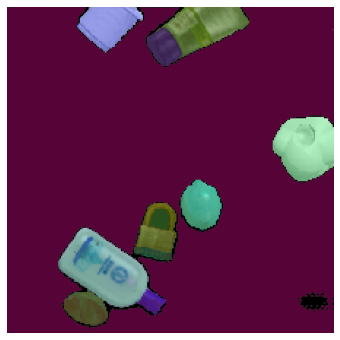

In [3]:


image = cv2.imread('assets/color_image.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
print(len(masks))
print(masks[0].keys())
plt.figure(figsize=(6,6))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

16


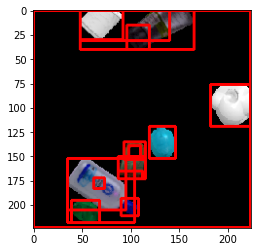

In [54]:
print(len(masks))
# draw rectangles around the object
# from xywh to xyxy
for mask in masks:
    x, y, w, h = np.array(mask['bbox']).astype(int)
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(image)

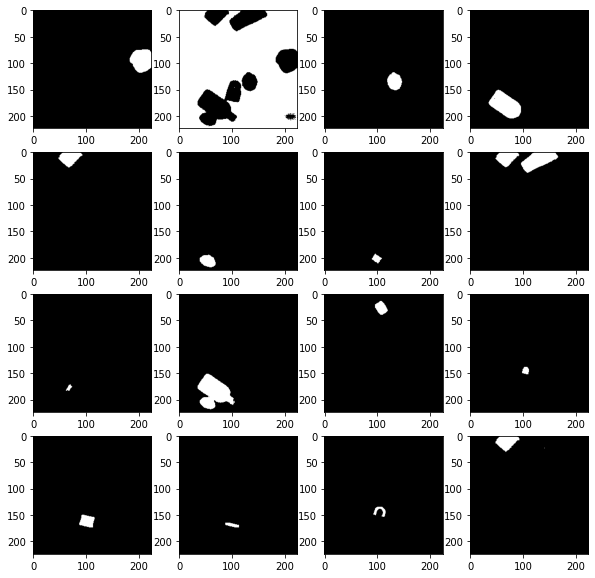

In [57]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(masks[i]['segmentation'], cmap='gray')

In [4]:
hmap = np.load('assets/hmap.npy')
# print(hmap)
# hmap = np.where(hmap > 3.896484e-05, 1, 0)
# plot a 10*10 grid on the heatmap
plt.figure(figsize=(6,6))

# num_grids = 6

# for i in np.linspace(0, hmap.shape[0], num_grids).astype(int):
#     plt.axhline(y=i, color='r', linestyle='-')
#     plt.axvline(x=i, color='r', linestyle='-')

# # see if there is any object in the heatmap
# for i in range(0, hmap.shape[0], num_grids):
#     for j in range(0, hmap.shape[1], num_grids):
#         if hmap[i, j] == 1:
#             print(f'Object detected at ({i}, {j})')
#             break
plt.imshow(hmap)

NameError: name 'plt' is not defined

In [1]:
from models.networks import SAMGraspFusion
from sam_hq.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import numpy as np

sam_checkpoint = "assets/sam_hq_vit_tiny.pth"
model_type = "vit_tiny"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

model = SAMGraspFusion(sam_mask_generator=mask_generator)
image = cv2.imread('assets/color_image.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hmap = np.load('assets/hmap.npy')
features = model.encode_color(image, hmap)
print(features.shape)

/mnt/c/Users/Fried/Documents/GitHub/SAMG/sam_hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with sam_hq.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/mnt/c/Users/Fried/Documents/GitHub/SAMG/sam_hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_11m_224 in registry with sam_hq.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/mnt/c/Users/Fried/Documents/GitHub/SAMG/sam_hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_21m_224 in registry with sam_hq.segment_anything.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflict

<All keys matched successfully>


/mnt/c/Users/Fried/Documents/GitHub/SAMG/sam_hq/segment_anything/utils/amg.py:118: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  change_indices = diff.nonzero()


torch.Size([1, 512])


In [4]:
import torch
actions = torch.rand(1, 10, 7).to(device)
grasp_feat = model.encode_grasp(actions) # shape = [N, L', D]
print(actions.shape, grasp_feat.shape, 'grasp_feat 1')
grasp_feat = grasp_feat.permute(1, 0, 2)  # NL'D -> L'ND
grasp_feat.shape

torch.Size([1, 10, 7]) torch.Size([1, 10, 512]) grasp_feat 1


torch.Size([10, 1, 512])

In [1]:
from models.networks import SAMGraspFusion
from sam_hq.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2, torch
import numpy as np

sam_checkpoint = "assets/sam_hq_vit_tiny.pth"
model_type = "vit_tiny"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

model = SAMGraspFusion(sam_mask_generator=mask_generator)
image = cv2.imread('assets/color_image.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hmap = np.load('assets/hmap.npy')

actions = torch.rand(1, 10, 7).to(device)

features = model(image, hmap, actions)
print(features.shape)

/mnt/c/Users/Fried/Documents/GitHub/SAMG/sam_hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with sam_hq.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/mnt/c/Users/Fried/Documents/GitHub/SAMG/sam_hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_11m_224 in registry with sam_hq.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/mnt/c/Users/Fried/Documents/GitHub/SAMG/sam_hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_21m_224 in registry with sam_hq.segment_anything.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflict

<All keys matched successfully>


/mnt/c/Users/Fried/Documents/GitHub/SAMG/sam_hq/segment_anything/utils/amg.py:118: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  change_indices = diff.nonzero()


torch.Size([10, 1, 512])


In [2]:
features.permute(1, 0, 2).shape

torch.Size([1, 10, 512])

In [40]:
# downsample the segmentation mask from 1*224*224 to 1*56*56
from torchvision.models import resnet18
from torch import nn

# load the pre-trained ResNet-18 model
cnn_encoder = resnet18(pretrained=True).cuda()
cnn_encoder.fc = nn.Identity()
# downsample the segmentation mask from 1*224*224 to 1*56*56
new_segs = segs.unsqueeze(1)
new_segs = new_segs.repeat(1, 3, 1, 1)
features = cnn_encoder(new_segs)
# use a simple LSTM to encode the features
lstm = nn.LSTM(input_size=512, hidden_size=512, num_layers=1, batch_first=True).cuda()
output, _ = lstm(features.unsqueeze(0))
output = output[:, -1, :]
print(output.size())

torch.Size([1, 512])


In [3]:
import os
import shutil

for folder in os.listdir('assets/simplified_objects/'):
    if os.path.isdir(f'assets/simplified_objects/{folder}'):
        try:
            shutil.copy(f'assets/simplified_objects/{folder}/texture_map.png', 
                        f'assets/{folder}.png')
        except:
            shutil.copy(f'assets/simplified_objects/{folder}/textured.jpg', 
                        f'assets/{folder}.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'assets/simplified_objects/068/textured.jpg'

<AxesSubplot:>

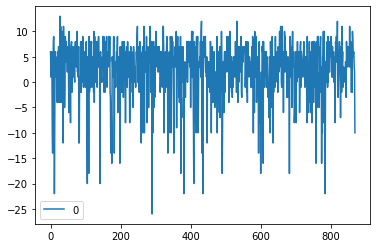

In [52]:
import pandas as pd

data = pd.read_csv('logs/2024-06-17-05-57-52-train/transitions/episode_reward.log.txt', header=None)
data.plot()

In [53]:
data.max()

0    13.0
dtype: float64